In [16]:
from sdv.single_table import CTGANSynthesizer, TVAESynthesizer
from sdv.metadata import SingleTableMetadata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance, ks_2samp
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report


In [17]:
# Load real dataset
df = pd.read_csv("augmented_dataset.csv")

# df = df.drop(columns=['BMI', 'BSA', 'IMT MAX', 'LVMi', 'EF', 'Record'])

df['Gender'] = df['Gender'].str.upper().map({'M': 0, 'F': 1})
df['Smoker'] = df['Smoker'].str.upper().map({'NO': 0, 'YES': 1})
df.head()

,Age,Weight,Height,SBP,DBP,Smoker,Gender,Vascular event
0,56,106.111813,182.646254,133.514419,80.460589,1,0,none
1,80,82.714286,163.022619,172.756876,75.963420,0,1,none
2,77,88.277426,179.782920,137.534457,87.152364,0,0,none
3,66,77.193632,174.844922,106.344249,65.522381,0,1,none
4,84,71.707697,167.620720,116.182451,73.078245,0,0,none


In [18]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)


In [19]:
use_ctgan = True  # Set to False to use TVAE instead

if use_ctgan:
    model = CTGANSynthesizer(metadata=metadata, epochs=500)
else:
    model = TVAESynthesizer(metadata=metadata, epochs=500)


/home/elukbog/.local/lib/python3.10/site-packages/sdv/single_table/base.py:119: FutureWarning:

The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.

/home/elukbog/.local/lib/python3.10/site-packages/sdv/single_table/base.py:104: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.



In [20]:
model.fit(df)

# Generate synthetic data
synthetic_crfs = model.sample(1000)
synthetic_crfs.to_csv("synthetic_crfs.csv", index=False)

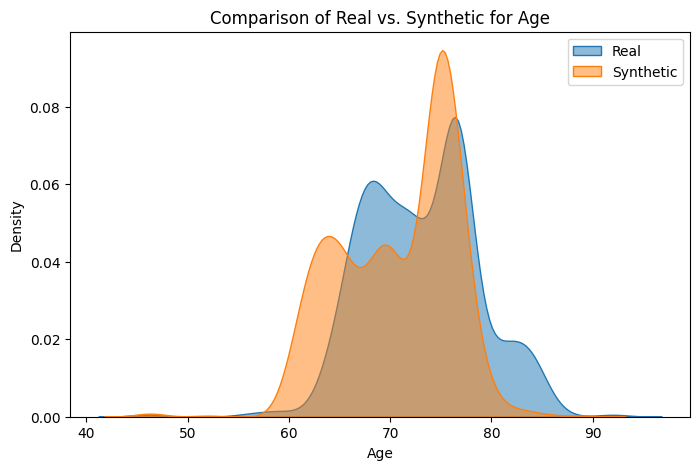

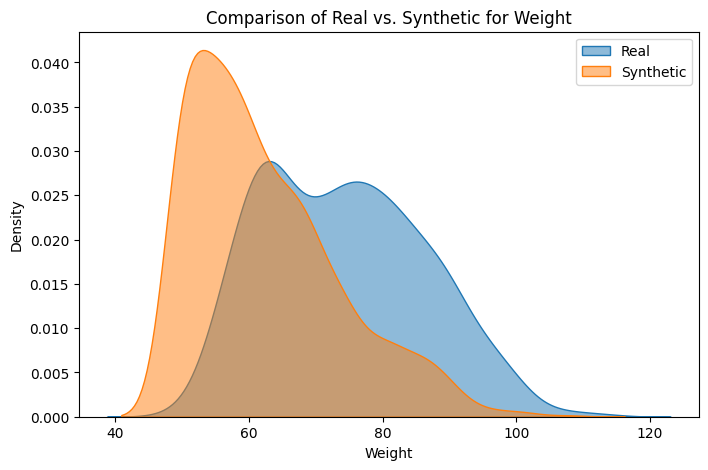

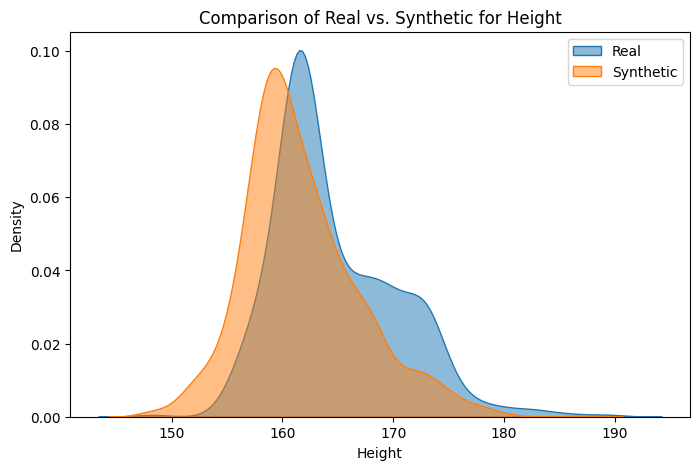

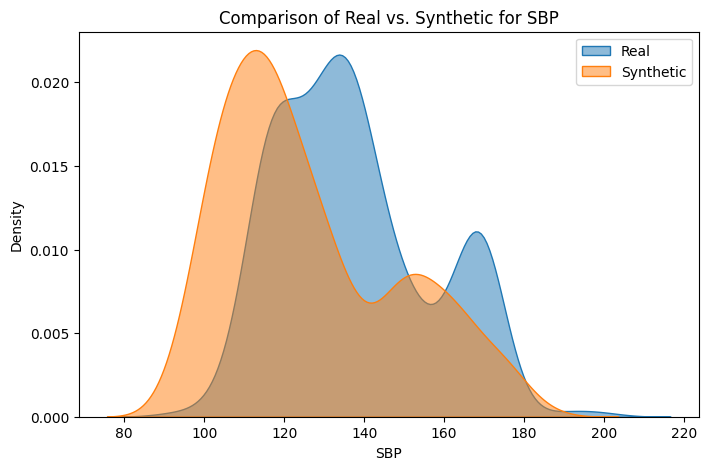

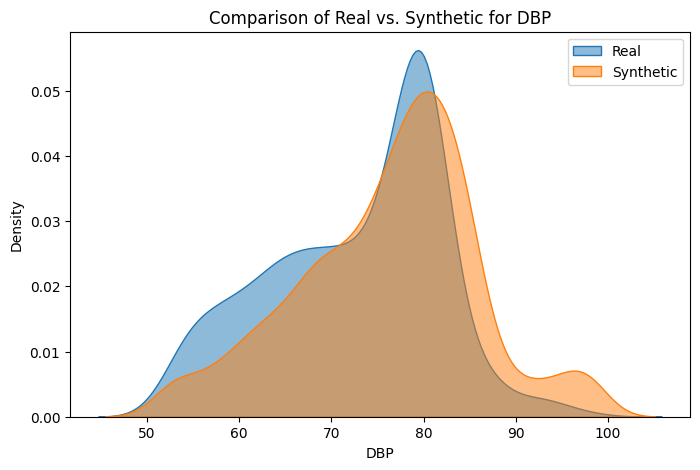

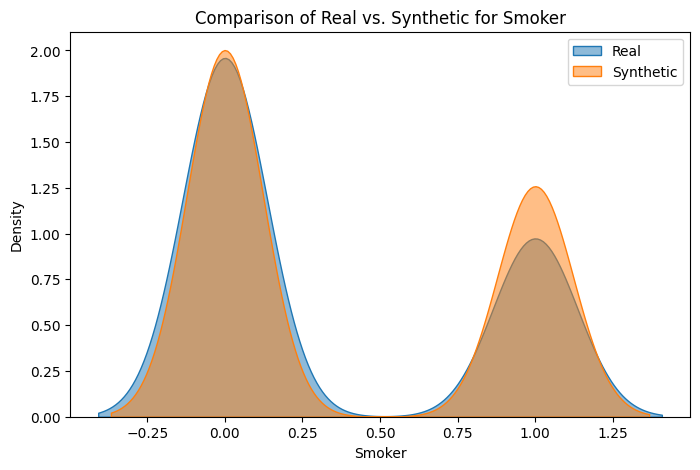

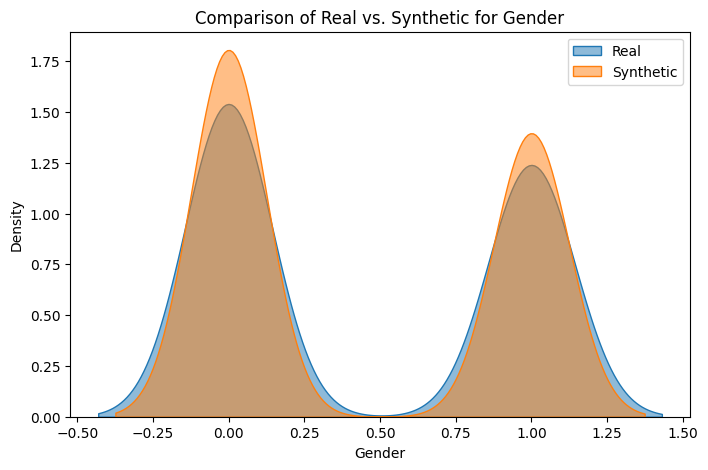

In [21]:

# Evaluation: Distribution Comparison
def distrib_comp():
    for column in df.columns:
        if column != "Vascular event":
            plt.figure(figsize=(8, 5))
            sns.kdeplot(df[column], label="Real", fill=True, alpha=0.5)
            sns.kdeplot(synthetic_crfs[column],
                        label="Synthetic", fill=True, alpha=0.5)
            plt.title(f"Comparison of Real vs. Synthetic for {column}")
            plt.legend()
            plt.show()

distrib_comp()

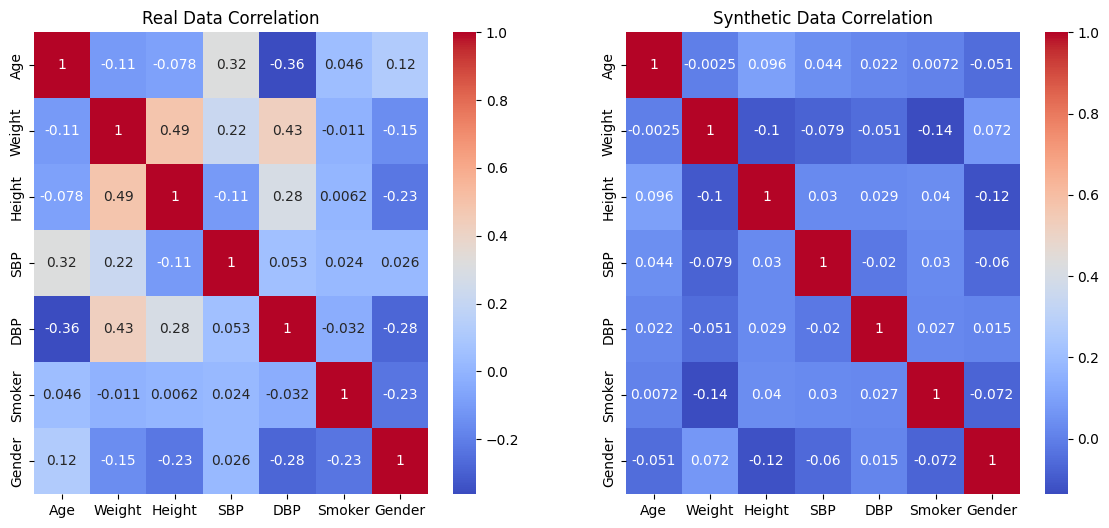

In [22]:
# Evaluation: Correlation Heatmaps
def correlation_heatmap():
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    sns.heatmap(df.drop(columns=["Vascular event"]).corr(), ax=axes[0], cmap="coolwarm", annot=True)
    axes[0].set_title("Real Data Correlation")
    sns.heatmap(synthetic_crfs.drop(columns=["Vascular event"]).corr(), ax=axes[1], cmap="coolwarm", annot=True)
    axes[1].set_title("Synthetic Data Correlation")
    plt.show()

correlation_heatmap()

In [23]:
# Evaluation: Statistical Distance Metrics
def stat_distance_metric():
    for column in df.columns:
        if column != 'Vascular event':
            wd = wasserstein_distance(df[column], synthetic_crfs[column])
            ks_stat, ks_p = ks_2samp(df[column], synthetic_crfs[column])
            print(f"Feature: {column}")
            print(f"  Wasserstein Distance: {wd:.4f}")
            print(f"  KS Test p-value: {ks_p:.4f}")
            print("-" * 30)

stat_distance_metric()

Feature: Age
  Wasserstein Distance: 2.3480
  KS Test p-value: 0.0000
------------------------------
Feature: Weight
  Wasserstein Distance: 11.9738
  KS Test p-value: 0.0000
------------------------------
Feature: Height
  Wasserstein Distance: 3.0398
  KS Test p-value: 0.0000
------------------------------
Feature: SBP
  Wasserstein Distance: 11.1124
  KS Test p-value: 0.0000
------------------------------
Feature: DBP
  Wasserstein Distance: 3.5401
  KS Test p-value: 0.0000
------------------------------
Feature: Smoker
  Wasserstein Distance: 0.0540
  KS Test p-value: 0.2822
------------------------------
Feature: Gender
  Wasserstein Distance: 0.0100
  KS Test p-value: 1.0000
------------------------------


In [24]:
target_column = "Vascular event"
X_real = df.drop(columns=[target_column])
X_real = X_real.fillna(X_real.mean())
y_real = df[target_column]
X_syn = synthetic_crfs.drop(columns=[target_column])
X_syn = X_syn.fillna(X_syn.mean())
y_syn = synthetic_crfs[target_column]

In [25]:
# Train on real, test on synthetic
X_train, X_test, y_train, y_test = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
pred_syn = clf.predict(X_syn)
real_to_syn_acc = accuracy_score(y_syn, pred_syn)

In [26]:
# Train on synthetic, test on real
X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(
    X_syn, y_syn, test_size=0.2, random_state=42)
clf_syn = RandomForestClassifier()
clf_syn.fit(X_train_syn, y_train_syn)
pred_real = clf_syn.predict(X_real)
syn_to_real_acc = accuracy_score(y_real, pred_real)

print(f"Train on Real → Test on Synthetic Accuracy: {real_to_syn_acc:.4f}")
print(f"Train on Synthetic → Test on Real Accuracy: {syn_to_real_acc:.4f}")

Train on Real → Test on Synthetic Accuracy: 0.2610
Train on Synthetic → Test on Real Accuracy: 0.2180


In [ ]:
print(f"Train on Real → Test on Synthetic Classification Report:\n{classification_report(y_syn, pred_syn)}")
print(f"Train on Synthetic → Test on Real Classification Report:\n{classification_report(y_real, pred_real)}")

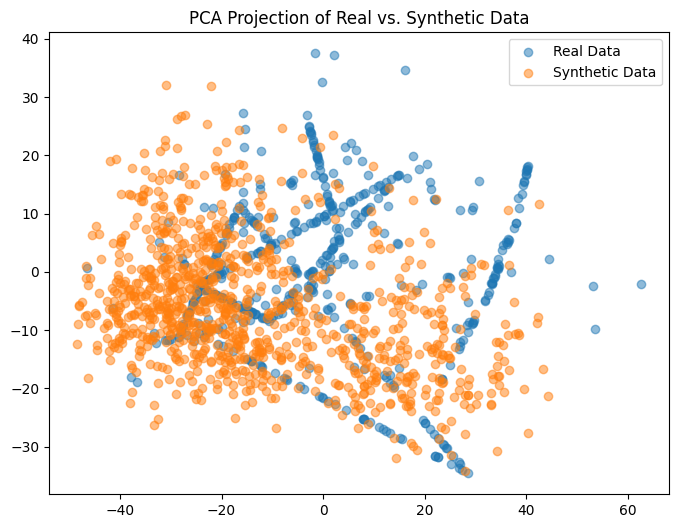

In [27]:
pca = PCA(n_components=2)
real_pca = pca.fit_transform(X_real)
synthetic_pca = pca.transform(X_syn)
plt.figure(figsize=(8, 6))
plt.scatter(real_pca[:, 0], real_pca[:, 1], label="Real Data", alpha=0.5)
plt.scatter(synthetic_pca[:, 0], synthetic_pca[:, 1],
            label="Synthetic Data", alpha=0.5)
plt.legend()
plt.title("PCA Projection of Real vs. Synthetic Data")
plt.show()